In [96]:
library(tidyverse)
library(leaps) # Subset selection
library(glmnet) # Ridge/Lasso
library(gam)
library(tree)
library(e1071)
library(randomForest)

In [97]:
df = read.csv("./data/cleaned_listing_dc.csv")
cleaned_df = df %>% dplyr::select(host_has_profile_pic, host_identity_verified, longitude, latitude, accommodates, bathrooms, beds, price, number_of_reviews, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, instant_bookable, reviews_per_month, host_length)

# Separate non-numeric columns
non_numeric_cols = cleaned_df[, !sapply(cleaned_df, is.numeric)]
numeric_cols = cleaned_df[, sapply(cleaned_df, is.numeric)]

# Normalize numeric columns
normalized_numeric_cols = as.data.frame(scale(numeric_cols))

# Combine back together
cleaned_df = cbind(normalized_numeric_cols, non_numeric_cols)
cleaned_df$price = log(df$price)
# cleaned_df$price = df$price
head(cleaned_df)

,longitude,latitude,accommodates,bathrooms,beds,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,host_length,host_has_profile_pic,host_identity_verified,instant_bookable
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,-0.8981083,0.3509227,-0.5611544,-0.5270125,-0.9351483,4.094345,0.1733423,-0.75123207,-0.3074395,-1.90391199,-0.126906964,-0.08933873,0.403875219,-0.6331848,-0.8332018,2.408087,t,t,f
2,-2.7730365,0.3973292,-0.9799366,-0.5270125,-0.2209855,4.189655,0.1252332,0.07332251,-0.1211679,0.25322286,0.247736693,0.13749832,0.082956498,0.3099247,-0.8383445,2.295420,t,t,f
3,-2.0631912,0.6554654,-0.1423722,-0.5270125,0.4931773,4.442651,3.2138381,-0.49533582,-0.4937111,-0.53383986,-0.002025745,0.08078906,0.189929405,-0.2508431,0.1336245,2.214300,t,t,f
4,-0.6145604,0.7441350,-0.9799366,-0.5270125,-0.2209855,4.828314,-0.3847234,0.21548709,0.3445110,0.16577145,0.435058522,0.33598074,0.002726818,0.3863930,-0.9977680,2.134081,t,t,f
5,0.6870938,-0.4089840,-0.1423722,-0.5270125,0.4931773,6.469250,-0.6252689,0.01645667,-0.9593901,-1.55410634,-0.345449097,-0.28782115,0.644564260,0.1569880,-1.0749084,1.980854,t,t,f
6,0.1954373,2.3244425,-1.3987188,-0.5270125,-0.9351483,4.174387,-0.6445126,0.67041376,-0.6489375,0.04916956,0.435058522,0.42104463,-1.494893881,-0.7351426,-1.0800511,2.195372,t,t,f


In [98]:
# Train and test split
set.seed(0223)
indices = sample(nrow(cleaned_df), size = nrow(cleaned_df)*0.8, replace = FALSE)
train = cleaned_df[indices,]
test = cleaned_df[-indices,]

# Subset Selection

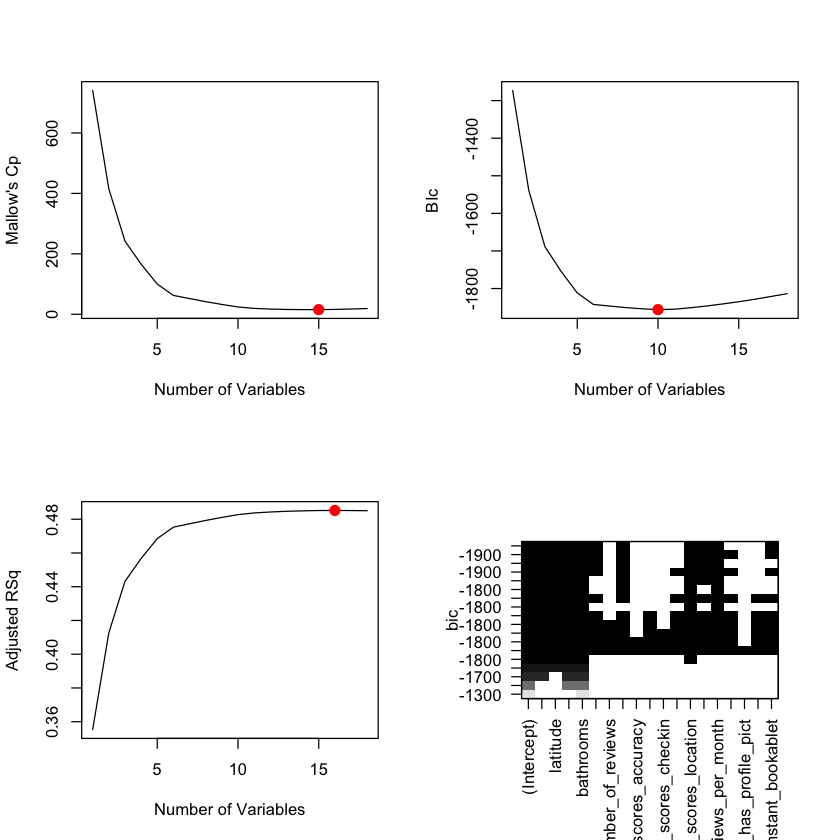

In [99]:
regfit.best = regsubsets(price~.,train, nvmax = ncol(train))
reg.summary=summary(regfit.best)

par(mfrow=c(2,2))
plot(reg.summary$cp,xlab="Number of Variables",ylab="Mallow's Cp",type="l")
points(which.min(reg.summary$cp),reg.summary$cp[which.min(reg.summary$cp)],col="red",cex=2,pch=20)

plot(reg.summary$bic,xlab="Number of Variables",ylab="BIc",type="l")
points(which.min(reg.summary$bic),reg.summary$bic[which.min(reg.summary$bic)],col="red",cex=2,pch=20)

plot(reg.summary$adjr2,xlab="Number of Variables",ylab="Adjusted RSq",type="l")
points(which.max(reg.summary$adjr2),reg.summary$adjr2[which.max(reg.summary$adjr2)],col="red",cex=2,pch=20)

plot(regfit.best,scale="bic")

In [100]:
print(coef(regfit.best,which.min(summary(regfit.best)$bic)))

           (Intercept)              longitude               latitude 
            4.96099910            -0.10660395            -0.07203328 
          accommodates              bathrooms                   beds 
            0.18071113             0.17078764             0.04470738 
  review_scores_rating review_scores_location    review_scores_value 
            0.05846420             0.05013689            -0.04141853 
     reviews_per_month      instant_bookablet 
           -0.04338568            -0.05023312 


# LASSO

[1] "Test MSE (lasso):  0.360283043630977"

[1] "R2 (lasso):  0.541574894016884"

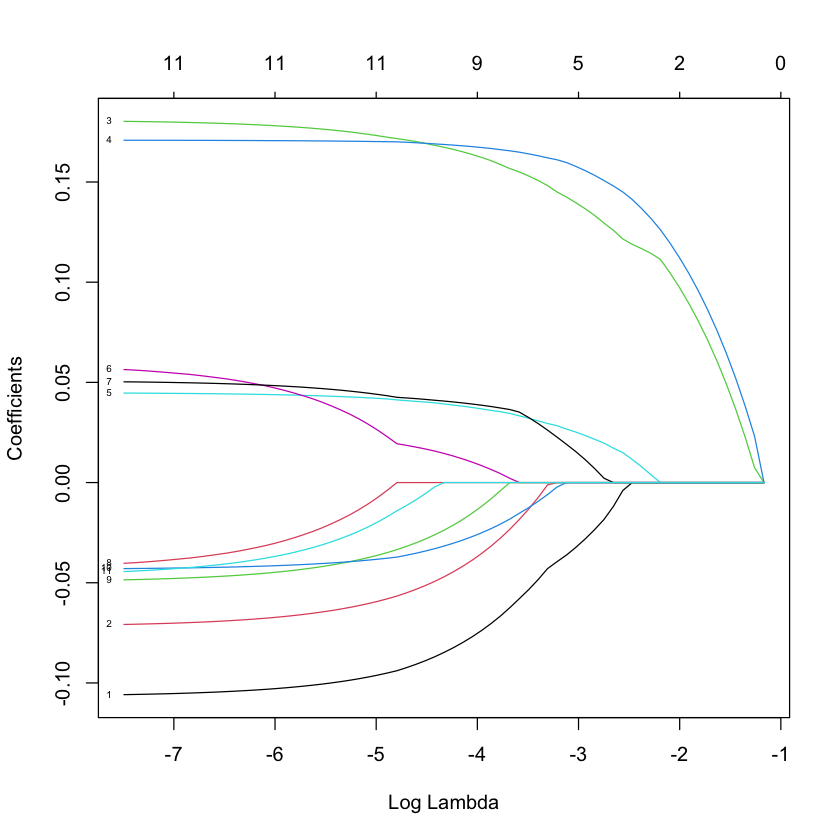

In [101]:
x = model.matrix(price ~ longitude+latitude+accommodates+bathrooms+beds+review_scores_rating+review_scores_location+review_scores_value+instant_bookable+reviews_per_month+host_identity_verified,train)[,-1]
y = train$price

lasso.fit = glmnet(x, y, alpha = 1)
plot(lasso.fit, xvar="lambda", label = TRUE)

cv.lasso.fit = cv.glmnet(x, y, alpha = 1, nfolds = 10)
# plot(cv.lasso.fit)

x_test = model.matrix(price ~ longitude+latitude+accommodates+bathrooms+beds+review_scores_rating+review_scores_location+review_scores_value+instant_bookable+reviews_per_month+host_identity_verified,test)[,-1]
y_test = test$price

y_pred = predict.glmnet(lasso.fit, s = cv.lasso.fit$lambda.min, newx = x_test)
error = sqrt(mean((test$price - y_pred)**2))
paste("Test MSE (lasso): ",error)

R2 = cor(y_test, y_pred)**2
paste("R2 (lasso): ", R2[1])

In [102]:
coef(cv.lasso.fit, cv.lasso.fit$lambda.1se)

12 x 1 sparse Matrix of class "dgCMatrix"
                                  s1
(Intercept)              4.948988563
longitude               -0.070358454
latitude                -0.031712841
accommodates             0.160643928
bathrooms                0.166720973
beds                     0.036013018
review_scores_rating     0.006530840
review_scores_location   0.037954532
review_scores_value      .          
instant_bookablet       -0.008104653
reviews_per_month       -0.022992008
host_identity_verifiedt  .          

# Linear Regression

In [103]:
lin.fit = glm(price ~ ., data = train)
lin.fit2 = glm(price ~ .+beds*accommodates, data = train)
lin.fit3 = glm(price ~ .+longitude*latitude, data = train)
stargazer::stargazer(lin.fit,lin.fit2,lin.fit3, type="text")


                                  Dependent variable:       
                            --------------------------------
                                         price              
                               (1)        (2)        (3)    
------------------------------------------------------------
longitude                   -0.108***  -0.107***  -0.109*** 
                             (0.008)    (0.008)    (0.008)  
                                                            
latitude                    -0.071***  -0.071***  -0.075*** 
                             (0.008)    (0.008)    (0.008)  
                                                            
accommodates                 0.183***   0.190***   0.186*** 
                             (0.015)    (0.015)    (0.015)  
                                                            
bathrooms                    0.168***   0.175***   0.164*** 
                             (0.010)    (0.010)    (0.010)  
                       

In [104]:
pred = predict(lin.fit, test)
sqrt(mean((test$price - pred)**2))

[1] 0.359965

In [105]:
pred = predict(lin.fit2, test)
sqrt(mean((test$price - pred)**2))

[1] 0.3565432

In [106]:
pred = predict(lin.fit3, test)
sqrt(mean((test$price - pred)**2))

[1] 0.3593223

# GAM

In [107]:
gam.fit = gam(price ~ host_has_profile_pic + host_identity_verified + instant_bookable + s(longitude) + s(latitude) + s(accommodates) + s(bathrooms) + s(beds) + s(number_of_reviews) + s(review_scores_rating) + s(review_scores_accuracy) + s(review_scores_cleanliness) + s(review_scores_checkin) + s(review_scores_communication) + s(review_scores_location) + s(review_scores_value) + s(reviews_per_month) + s(host_length), data = train)
summary(gam.fit)
pred = predict(gam.fit, test)
sqrt(mean((test$price - pred)**2))

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2


Call: gam(formula = price ~ host_has_profile_pic + host_identity_verified + 
    instant_bookable + s(longitude) + s(latitude) + s(accommodates) + 
    s(bathrooms) + s(beds) + s(number_of_reviews) + s(review_scores_rating) + 
    s(review_scores_accuracy) + s(review_scores_cleanliness) + 
    s(review_scores_checkin) + s(review_scores_communication) + 
    s(review_scores_location) + s(review_scores_value) + s(reviews_per_month) + 
    s(host_length), data = train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-1.45751 -0.22618 -0.01233  0.20279  1.64241 

(Dispersion Parameter for gaussian family taken to be 0.1266)

    Null Deviance: 800.4968 on 2933 degrees of freedom
Residual Deviance: 363.3016 on 2870 degrees of freedom
AIC: 2327.532 

Number of Local Scoring Iterations: NA 

Anova for Parametric Effects
                                 Df Sum Sq Mean Sq   F value    Pr(>F)    
host_has_profile_pic              1   0.01   0.010    0.0811  0.775818    
host_i

[1] 0.3454025

[1] 0.5771607

# Random Forest

[1] 0.3392096

[1] 1.403838

[1] 0.5921873

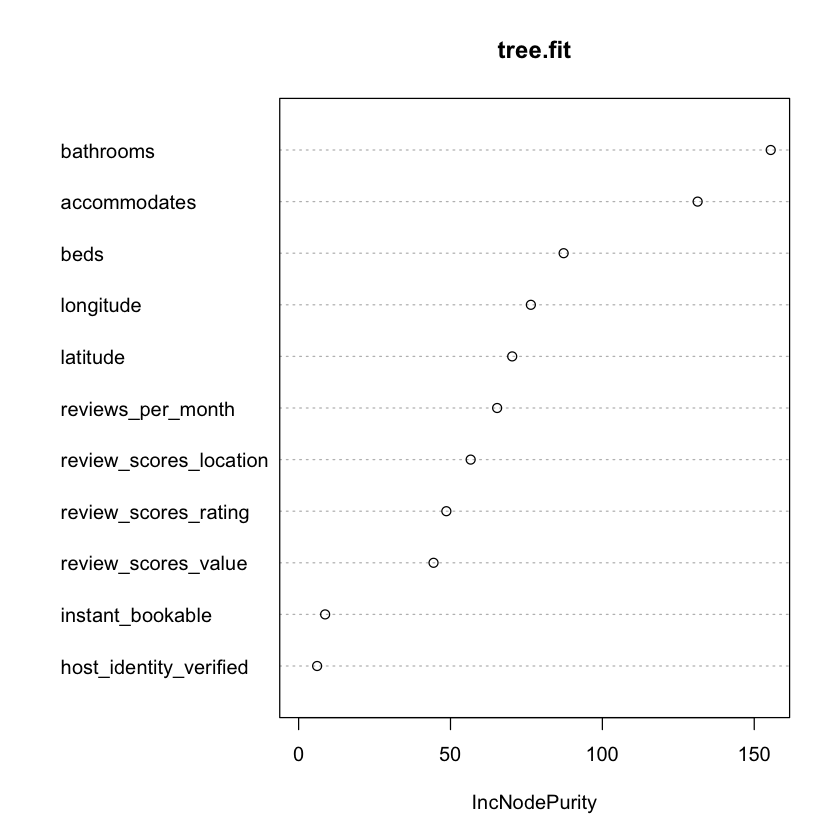

In [111]:
tree.fit = randomForest(price ~ longitude+latitude+accommodates+bathrooms+beds+review_scores_rating+review_scores_location+review_scores_value+instant_bookable+reviews_per_month+host_identity_verified, data = train)
# summary(tree.fit)
varImpPlot(tree.fit)
pred = predict(tree.fit, test)
sqrt(mean((test$price - pred)**2))

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2

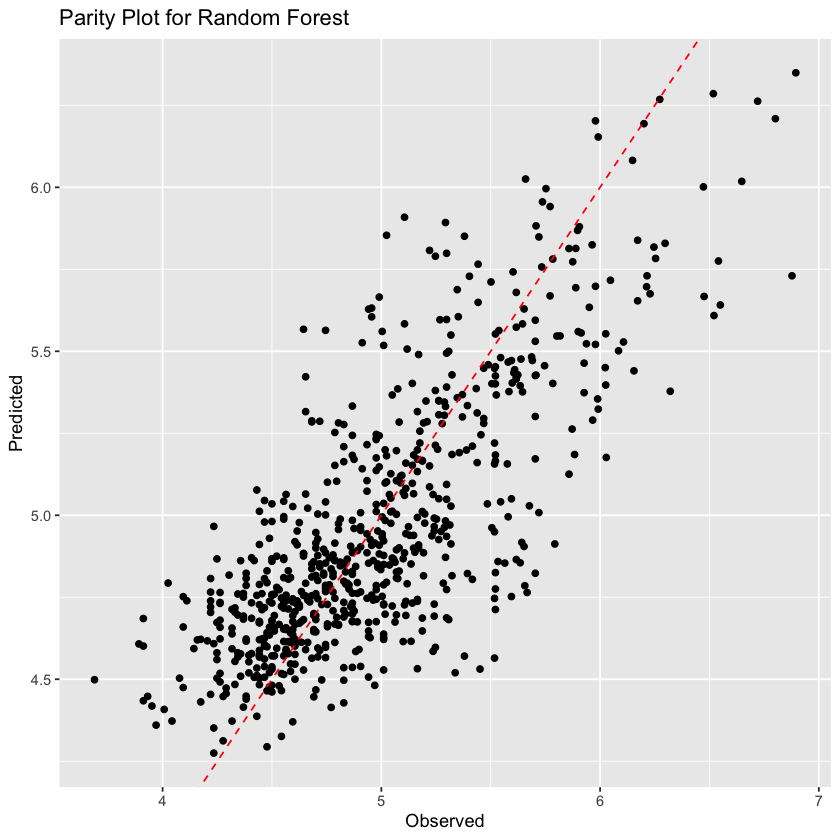

In [109]:
parity_data = data.frame(Observed = test$price, Predicted = pred)

# Create parity plot
ggplot(parity_data, aes(x = Observed, y = Predicted)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") + 
    labs(x = "Observed", y = "Predicted", title = "Parity Plot for Random Forest")

# SVM

In [110]:
svm.fit = svm(price ~ longitude+latitude+accommodates+bathrooms+beds+review_scores_rating+review_scores_location+review_scores_value+instant_bookable+reviews_per_month+host_identity_verified, data = train)
summary(svm.fit)
pred = predict(svm.fit, test)
sqrt(mean((test$price - pred)**2))

r2 = 1 - (sum((test$price - pred)^2) / sum((test$price - mean(test$price))^2))
r2


Call:
svm(formula = price ~ longitude + latitude + accommodates + bathrooms + 
    beds + review_scores_rating + review_scores_location + review_scores_value + 
    instant_bookable + reviews_per_month + host_identity_verified, 
    data = train)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.08333333 
    epsilon:  0.1 


Number of Support Vectors:  2523






[1] 0.3486119

[1] 0.5692664